In [104]:
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle as pkl

from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [89]:

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        max_depth=3,
        reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_true_train)

    y_pred = xgb_model.predict(x_test[:, features])
    y_pred_train = xgb_model.predict(x_train[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    auroc = metrics.roc_auc_score(y_true_test, y_pred)
        
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

def feature_idx(
    method: str,
    cohort: str,
    learner: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_{learner}.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_{learner}.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    indices  = [ x.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    indices = [i-1 if i > treatment_index else i for i in indices]
    
    return indices

In [107]:
ist3 = pd.read_sas("../data/datashare_aug2015.sas7bdat")

continuous_vars = [
    "gender",
    "age",
    "weight",
    "glucose",
    "gcs_eye_rand",
    "gcs_motor_rand",
    "gcs_verbal_rand",
    # "gcs_score_rand",   
     "nihss" ,
     "sbprand",
     "dbprand",
     "antiplat_rand"
                  ]

cate_variables = [
     # "livealone_rand",
     # "indepinadl_rand",
     "infarct",
     # "atrialfib_rand",
    #  "liftarms_rand",
    # "ablewalk_rand",
    # "weakface_rand",
    # "weakarm_rand",
    # "weakleg_rand",
    # "dysphasia_rand",
    # "hemianopia_rand",
    # "visuospat_rand",
    # "brainstemsigns_rand",
    # "otherdeficit_rand",
    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

x = ist3[continuous_vars + cate_variables + treatment]

x["antiplat_rand"] = np.where(x["antiplat_rand"]== 2, 0, 1)
x["gender"] = np.where(x["gender"]== 2, 1, 0)

x = pd.get_dummies(x, columns=cate_variables)

n, feature_size = x.shape

names = x.drop(["itt_treat"], axis=1).columns
treatment_index = x.columns.get_loc("itt_treat")

var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=60,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=10,
                                    )


w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:, var_index]
x_test = x_test[:, var_index]

y_train = y_train ==0
y_test = y_test == 0

/tmp/ipykernel_646435/3767982525.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 2, 0, 1)
/tmp/ipykernel_646435/3767982525.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["gender"] = np.where(x["gender"]== 2, 1, 0)


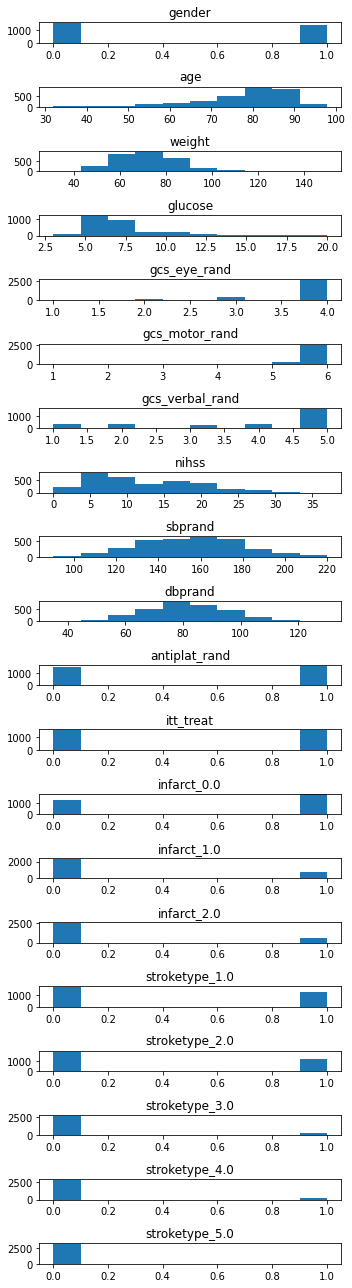

In [108]:

plt.figure(figsize=(5, 18))

for i, col in enumerate(x.columns):
    plt.subplot(len(x.columns),1,i+1 )
    plt.hist(x[col])
    plt.title(col)
    
plt.tight_layout()

In [87]:
learner = "TARNet"

results_train = pkl.load(open(f'../results/ist3/train_{learner}.pkl', "rb"))
results_test = pkl.load(open(f"../results/ist3/test_{learner}.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

# threshold_train = np.mean(results_train, axis=1).reshape(-1,1)
# thresohld_test = np.mean(results_test, axis=1).reshape(-1,1)

# y_true_train = np.where(np.mean((results_train > threshold_train), axis=0) > 0.5, 1, 0 )
# y_true_test = np.where(np.mean((results_test > thresohld_test), axis=0) > 0.5, 1, 0 )


estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

threshold = np.mean(estimated_ate_train, )

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

explainers = {
    "shap": feature_idx("shap","ist3", learner), #[gender,trauma ,cause_cut, edgcs, cause_mv ]
    "shap - 0 ": feature_idx("shap - 0 ","ist3",learner ), #[temp, ph, bd, hgb, trauma ]
    "ig": feature_idx("ig","ist3" ,learner), #[ph, na, temp, gender, trauma ],
    
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
    )
print("===================")
print("original", np.sum(estimated_ate_test[w_test==1])/n)


-8.978451145323896e-07 1.8619547253283968e-07
-1.0136777271483275e-06 3.7820628326323075e-07
['age', 'sbprand', 'gcs_verbal_rand', 'nihss', 'stroketype_5.0']
['age', 'sbprand', 'gcs_verbal_rand', 'nihss', 'stroketype_5.0']
['age', 'sbprand', 'gcs_verbal_rand', 'nihss', 'stroketype_5.0']
shap - auroc 0.4997611655123
shap - ATE -9.11460371657598e-07
shap - 0  - auroc 0.4997611655123
shap - 0  - ATE -9.11460371657598e-07
ig - auroc 0.4997611655123
ig - ATE -9.11460371657598e-07
full features - auroc 0.4851444948650585
full features - ATE -9.211953157128641e-07
random features - auroc 0.5024659660855028
random features - ATE -9.009120307175773e-07
original -1.0368343867710648e-07


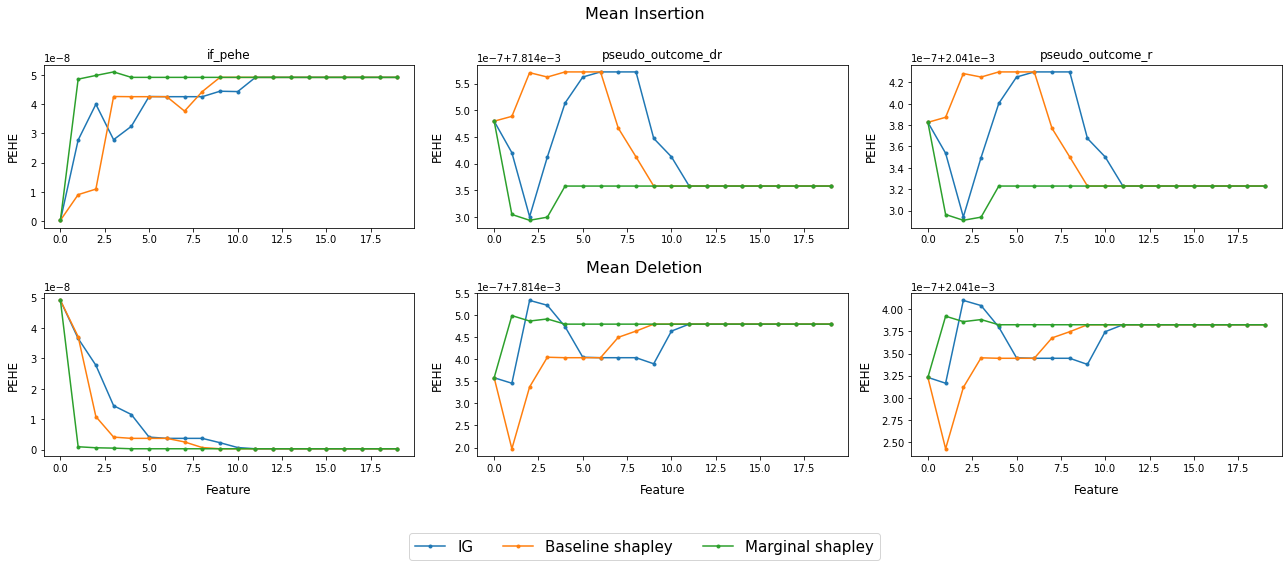

In [109]:
explainers = [
    "integrated_gradients", 
    "shapley_value_sampling",
    "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

# Loop over the different files

seeds = [0]

for file_num in range(1):  # assuming there are 5 files, from 0 to 4
    
    if file_num not in [1]:
        
        for selection_type in selection_types:
            file_path = f"../results/ist3/insertion_deletion_{learner}_{file_num}.pkl"
            results = pkl.load(open(file_path,'rb'))

            for exp_index, exp in enumerate(explainers):
                insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
                deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "naive_shap":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        
        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        
        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# # Function to calculate the percentage contribution of cumulative PEHE up to nth feature relative to the total PEHE at final feature
# def calc_cumulative_contribution(n, data):
#     if n >= len(data):
#         raise ValueError(f"Feature index {n} is out of bounds for data of length {len(data)}")
#     percentage_contribution = (data[-1] - data[n] / data[-1]) * 100
#     return percentage_contribution

# # Let's say you want the cumulative contribution of PEHE when up to the 5th feature is added
# n = 4

# # Loop through each explainer and selection type
# for exp in explainers:
#     for selection_type in selection_types:
#         # Get the cumulative PEHE for each feature
#         pehe_values = np.mean(insertion_results_all[exp][selection_type], axis=0)
#         percentage_contribution = calc_cumulative_contribution(n, pehe_values)
        
#         # Print the percentage contribution of PEHE up to nth feature
#         print(f"For {exp} with {selection_type} selection:")
#         print(f"Percentage contribution of PEHE up to {n+1}th feature: {percentage_contribution}%")
